# SVM Classification of Arrythmias from Single Lead ECG Recordings

In this project, we are going to use Support Vector Machine (SVM) to classify normal and abnormal rhythms from ECG Recordings.

A typical ECG looks like this:
<img src="misc/ecg.jpg">

where P waves = atrial depolarization;
      QRS complex = ventricular depolarization;
      T waves = ventricular repolarization

For more information about ECG and its interpretation, please see https://meds.queensu.ca/central/assets/modules/ts-ecg/index.html

# Data Source

ECG recordings are obtained from https://www.physionet.org/challenge/2017/. The training set contains 5154 normal ECGs and 3328 abnormal ECGs, which can further be broken down into 771 atrial fibrillations (AF) and 2557 other abnormal rhythms (O). Noisy recordings are excluded in this project.

# Feature selection

To avoid misdiagnosis, clinicians have developed a systematic approach to look for ECG anomalies. This approach can be broken down into three major steps, which consists of: 

1. Assessment of rhythm
    - heart rate
    - beat regularity
    - QRS complex interval
    - Atrial activity (Are P waves present?)
    - PR intervals
2. QRS axis/morphology
    - QRS mean electrical axis (can not be determined from a single lead)
    - Morphology of QRS complex 
3. ST segments, T waves, QT interval
    - QT interval adjusted for heart rate
    - ST elevations/depressions
    - T waves

We are going to use these metrics (with the exception of QRS axis since it cannot be determined from a single lead recording) as feature inputs for our learning model.

# Workflow

1. Train HMM for ECG segmentation using the cardIO HMM preprocess/train pipeline (may take several hours)
2. Initialize dataset using the features described above
3. Preprocess labels for binary classification
4. Fit SVM estimator using extracted features with the sklearn package
5. Evaluate model 


In [ ]:
# download QT database from PhysioNet (https://physionet.org/physiobank/database/qtdb/)
# train a Hidden Markov Model for ECG segmentation

from wfdb import dldatabase
dldatabase('qtdb', './data/qtdb')

In [9]:
from cardio import EcgDataset
from cardio.pipelines import hmm_preprocessing_pipeline, hmm_train_pipeline, hmm_predict_pipeline
import warnings 
warnings.filterwarnings('ignore')

C:\Users\mikeq\Anaconda3\lib\site-packages\dicom\__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)
C:\Users\mikeq\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
# train HMM with cardIO pipeline
# takes several hours to train

print('Generating ECG Dataset...')
qtdb = EcgDataset(path="./data/qtdb/*.hea", no_ext=True, sort=True)

print('Preprocessing dataset...')
pipeline = hmm_preprocessing_pipeline()
ppl_inits = (qtdb >> pipeline).run()

print('Training HMM')
pipeline = hmm_train_pipeline(ppl_inits)
ppl_train = (qtdb >> pipeline).run()

print('Task complete.')
ppl_train.save_model("HMM", path="./misc/hmm_model.dll")

In [10]:
# sample prediction using trained HMM for ECG segmentation
eds = EcgDataset(path="./data/ECG/A00085.hea", no_ext=True, sort=True)
batch = (eds >> hmm_predict_pipeline("./misc/hmm_model.dll", annot="hmm_annotation")).next_batch()

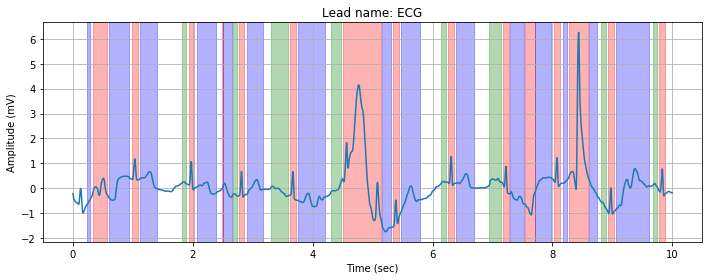

P waves - green
QRS - red
T - blue

[{'counterfreq': None, 'signame': array(['ECG'], dtype='<U3'), 'sampsperframe': [1], 'nsig': 1, 'byteoffset': [24], 'blocksize': [0], 'comments': [], 'p_segments': array([[ 545,  800,  992, 1291, 1844, 2081, 2644, 2903, 3138, 3384, 3644,
        3862, 4114, 4374, 4591, 4877, 5139, 5382, 5650, 5902, 6145, 6413,
        6692, 6952, 7234, 7474, 8023, 8817],
       [ 568,  820, 1075, 1343, 1868, 2143, 2669, 2925, 3162, 3406, 3653,
        3885, 4137, 4397, 4638, 4902, 5163, 5404, 5673, 5927, 6169, 6431,
        6717, 6978, 7257, 7535, 8047, 8838]], dtype=int64), 'fs': 300, 'siglen': 9000, 'baseline': [0], 'age': None, 'units': array(['mV'], dtype='<U2'), 'qrs': 0.09333333333333334, 'e_d_signals': None, 'filename': ['A00085.mat'], 'qt': 0.43, 'timestamp': None, 'basecounter': None, 'd_signals': None, 't_segments': array([[  69,  183,  337,  620,  752,  869, 1129, 1549, 1642, 1919, 2190,
        2313, 2451, 2581, 2720, 2975, 3212, 3458, 3587, 3707, 3937, 4

In [11]:
batch.show_ecg("A00085", start=0, end=10, annot="hmm_annotation")
print("P waves - green")
print("QRS - red")
print("T - blue")
print('')
print(batch.meta)

In [ ]:
# initialize dataset with features discussed previously (heart rate, beat regularity, important intervals, etc)

# Note on segment interval and AUC calculations:

# As shown above, the meta components of the HMM predictions contain two arrays for important ECG segments.
# The first array gives the sampling index at the beginning of a segment, while the second array gives the
# sampling index at the end of a segment. Since the sampling rate is 300 Hz, we can calculate any segment interval
# with (array_2 - array_1) / 300. Some intervals such as QT, QRS, PQ are already provided in the meta component.
# We can also calculate the AUC of a given segment by indexing the signal array, and adding the sliced amplitude values.

# The following recordings are missing key annotations, hence the excessive try/except patterns: 
# A00549, A03560, A04399, A05492, A06920, A07732, A07887
# there might be a better way to handle these exceptions ...

from os.path import join
import pandas as pd
import numpy as np
from statistics import median
from math import sqrt
from IPython.display import clear_output

def peak_height(key, meta_data, index_file, signal): # calculates the AUC of a peak (eg. P, QRS, T, etc)
    
    peaks = []
    start_idx = meta_data[index_file].meta[key][0]
    end_idx = meta_data[index_file].meta[key][1]
    
    for i, v in enumerate(start_idx):
        p = signal[v:end_idx[i]].max() - signal[v:end_idx[i]].min()
        peaks.append(p)
    
    if len(peaks) != 0:
        return median(peaks)
    else:
        return 0
# Since we are only doing binary classification, we are going to re-label the
# classes into binaries: 0 - normal rhythms; 1 - arrhythmias

df = pd.read_csv('./data/ECG/REFERENCE.csv', header=None, names=['recordings', 'labels'])
df = df.replace(to_replace='N', value=0)
df = df.replace(to_replace='O', value=1)
df = df.replace(to_replace='A', value=1)

# Remove 'Noisy' labels so that we only have 2 classes
df = df[df['labels'] != '~']

# features associated with each step

# step 1: assess the rhythm
heart_rate = [] 
beat_regularity = []
QRS_width = [] # width of QRS complex
atrial_activity = [] # median AUC of P waves
PR_interval = []
missing_Ps = [] # number of missing P waves relative to QRS complexes

# step 2: assess the QRS axis/morphology
# since the axis cannot be determined from single lead, we are only going to evaluate the morphology
QRS_morphology = [] # median AUC of QRS

# step 3: ST elevation, QT intervals
QTI = [] # adjusted for heart rate: QT_interval / sqrt(heart_rate)
T_height = [] # median AUC of T waves to look for peaked T waves, which may suggest hyperkalemia or early transition to ST-elevation MI


i = 0 
for idx in df['recordings']: 
    file = EcgDataset(path=join('./data/ECG/', idx + ".hea"), no_ext=True)
    pred = (file >> hmm_predict_pipeline("hmm_model.dll", annot="hmm_annotation")).next_batch()
    signal = pred[idx].signal[0] # array for signal values

    # heart rate
    try:
        heart_rate.append(pred[idx].meta['hr'])
    except KeyError:
        print('Key error for heart rate:', idx)
        heart_rate.append(0)

    # beat regularity: standard deviation of RR intervals
    try:
        rr = np.subtract(pred[idx].meta['qrs_segments'][0][1:], pred[idx].meta['qrs_segments'][0][0:-1])
        rr = np.divide(np.squeeze(rr), 300)
        beat_regularity.append(np.std(rr))
    except KeyError:
        print('Key error for beat irregularity:', idx)
        beat_regularity.append(-1)
    
    # Width of QRS segments
    try:
        QRS_width.append(pred[idx].meta['qrs'])
    except KeyError:
        print('Key error for QRS width:', idx)
        QRS_width.append(-1)
        
    # Atrial activity
    try:
        atrial_activity.append(peak_height('p_segments', pred, idx, signal))
    except KeyError:
        print('Key error for atrial activity:', idx)
        atrial_activity.append(0)
        
    # Changes in PR interval
    try:
        PR_interval.append(pred[idx].meta['pq'])
    except KeyError:
        print('Key error for PR interval:', idx)
        PR_interval.append(-1)
         
    # number of missing P waves relative QRS complexes
    try:
        missing_Ps.append(len(pred[idx].meta['qrs_segments'][0]) - len(pred[idx].meta['p_segments'][0]))
    except KeyError:
        print('Key error, missing P waves:', idx)
        missing_Ps.append(-1)
    
    # QRS morphology
    try:
        QRS_morphology.append(peak_height('qrs_segments', pred, idx, signal))
    except KeyError:
        print('Key error, QRS morphology:', idx)
        QRS_morphology.append(0)
    
    # T wave amplitude
    try:
        T_height.append(peak_height('t_segments', pred, idx, signal))
    except KeyError:
        T_height.append(0)
    
    # QT interval adjusted for heart rate
    try:
        QT_interval = pred[idx].meta['qt'] / sqrt(median(rr))
        QTI.append(QT_interval)
    except KeyError:
        print('Key error, QT interval:', idx)
        QTI.append(0)

clear_output()

# initialize dataset
ds = pd.DataFrame()
ds['recordings'] = df['recordings'].values
ds['heart_rate'] = heart_rate
ds['beat_regularity'] = beat_regularity
ds['QRS_width'] = QRS_width
ds['atrial_activity'] = atrial_activity
ds['PR_interval'] = PR_interval
ds['missing_Ps'] = missing_Ps
ds['QRS_morphology'] = QRS_morphology
ds['T_waves'] = T_height
ds['QT_interval'] = QTI
ds['labels'] = df['labels'].values

print('Length of dataset:', len(ds))
print(ds.head(10))

# save dataset
ds.to_csv('ecg_dataset.csv', index=False)

In [15]:
from sklearn import svm, preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import numpy as np

# import data
df = pd.read_csv('ecg_dataset.csv')

features = ['heart_rate', 'beat_regularity', 'PR_interval', 'QRS_width', 'T_waves', 'QT_interval',
           'atrial_activity', 'QRS_morphology', 'missing_Ps']

# add some more features: temporal and amplitude ratios
df['qt_ratio'] = df['QRS_morphology'] / df['T_waves']
df['qp_ratio'] = df['QRS_morphology'] / df['atrial_activity']
df['pq_interval_ratio'] = df['PR_interval'] / df['QRS_width']

# normalize
X = df[features].values
X_scaled = preprocessing.scale(X) # (X - X.mean) / X.std = N(0,1)
y = df['labels']

# # split data for training/validation/test. Here, we use the k-fold cross validation for hyperparameter selection
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=1, train_size=0.8, test_size=0.2)

# train model

parameters = [{'C': [0.005, 0.5, 1, 2, 4], 'gamma': [1, 2, 4], 'kernel': ['rbf']}]

model = svm.SVC(class_weight={1:2}) # adjust for class imbalance
GridSearch = GridSearchCV(model, parameters, scoring='roc_auc', cv=5, verbose=1, return_train_score=False)
GridSearch.fit(X_train, y_train)

# # validation results
results = pd.DataFrame(GridSearch.cv_results_)
print('Done!')


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  1.6min finished


Done!


In [16]:
# After performing grid search on hyperparameters C and gamma on the validation set, we make predictions with the best estimator
# on the test set:

print('ROC AUC:', GridSearch.score(X_test, y_test))

ROC AUC: 0.7616439433253134


# Summary

In this project, we used a SVM classifier to discriminate between normal and abnormal rhythms provided in the 2017 PhysioNet Cardiology Challenge. This simple SVM model was able to achieve reasonable test score (ROC AUC = 0.76) with only 15 features, which is signifcantly less compared to the number of features used in similar literature (>100 local and global features). 

- More discriminant features can be introduced using advanced signal processing techniques
- Other classification models, which doesn't rely on feature selection, can be trained on this dataset. CNN-like models is a popular choice for this type of application
